# Gözetimsiz Öğrenme ile Müşteri Segmentasyonu (Customer Segmentation with Unsupervised Learning)

### İş Problemi (Business Problem)

Unsupervised Learning yöntemleriyle (Kmeans, Hierarchical Clustering )  müşteriler kümelere ayrılıp ve davranışları gözlemlenmek istenmektedir.

### Veri Seti Hikayesi

Veri seti son alışverişlerini 2020 - 2021 yıllarında OmniChannel(hem online hem offline) olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.

### Veriseti Hakkında

#### 20.000 gözlem, 13 değişken

* master_id: Eşsiz müşteri numarası
* order_channel : Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile, Offline)
* last_order_channel : En son alışverişin yapıldığı kanal
* first_order_date : Müşterinin yaptığı ilk alışveriş tarihi
* last_order_date : Müşterinin yaptığı son alışveriş tarihi
* last_order_date_online : Muşterinin online platformda yaptığı son alışveriş tarihi
* last_order_date_offline : Muşterinin offline platformda yaptığı son alışveriş tarihi
* order_num_total_ever_online : Müşterinin online platformda yaptığı toplam alışveriş sayısı
* order_num_total_ever_offline : Müşterinin offline'da yaptığı toplam alışveriş sayısı
* customer_value_total_ever_offline : Müşterinin offline alışverişlerinde ödediği toplam ücret
* customer_value_total_ever_online : Müşterinin online alışverişlerinde ödediği toplam ücret
* interested_in_categories_12 : Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi
* store_type : 3 farklı companyi ifade eder. A company'sinden alışveriş yapan kişi B'dende yaptı ise A,B şeklinde yazılmıştır.


### Projenin Aşamaları

* GÖREV 1: Veriyi Hazırlama
            1. flo_data_20K.csv.csv verisini okuyunuz.
            2. Müşterileri segmentlerken kullanacağınız değişkenleri seçiniz. Tenure(Müşterinin yaşı), Recency (en son kaç gün önce alışveriş yaptığı) gibi yeni değişkenler oluşturabilirsiniz.

* GÖREV 2: K-Means ile Müşteri Segmentasyonu
            1. Değişkenleri standartlaştırınız.
            2. Optimum küme sayısını belirleyiniz.
            3. Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.
            4. Herbir segmenti istatistiksel olarak inceleyeniz.

* GÖREV 3: Hierarchical Clustering ile Müşteri Segmentasyonu
           1. Görev 2'de standırlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz.
           2. Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.
           3. Herbir segmenti istatistiksel olarak inceleyeniz.


## Importing Dataset, Required Library and Functions:

In [6]:
# Gerekli kütüphanelerin yüklenmesi:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
# from yellowbrick.cluster import KElbowVisualizer

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)

### Data Preparation

#### GÖREV 1: Veri setini okutunuz ve müşterileri segmentlerken kullanıcağınız değişkenleri seçiniz.


In [19]:
df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [20]:
# tarih değişkenine çevirme
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

df["last_order_date"].max() # 2021-05-30
analysis_date = dt.datetime(2021,6,1)

df["recency"] = (analysis_date - df["last_order_date"]).astype('timedelta64[D]') # en son kaç gün önce alışveriş yaptı
df["tenure"] = (df["last_order_date"]-df["first_order_date"]).astype('timedelta64[D]')

model_df = df[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.00,1.00,139.99,799.38,95.00,119.00
1,19.00,2.00,159.97,1853.58,105.00,1469.00
2,3.00,2.00,189.97,395.35,186.00,366.00
3,1.00,1.00,39.99,81.98,135.00,11.00
4,1.00,1.00,49.99,159.99,86.00,582.00


#### GÖREV 2: K-Means ile Müşteri Segmentasyonu


##### 1. Değişkenleri standartlaştırınız.
* SKEWNESS

order_num_total_ever_online's: Skew: 0.7748337692172717, : SkewtestResult(statistic=39.78989117917347, pvalue=0.0)
order_num_total_ever_offline's: Skew: 0.9885379987907902, : SkewtestResult(statistic=48.17413298491169, pvalue=0.0)
customer_value_total_ever_offline's: Skew: -0.4909513202118425, : SkewtestResult(statistic=-26.841359965843573, pvalue=1.0639875940990984e-158)
customer_value_total_ever_online's: Skew: -0.15625579457120184, : SkewtestResult(statistic=-8.958340067230154, pvalue=3.2960261321237205e-19)
recency's: Skew: -1.3833783786735552, : SkewtestResult(statistic=-61.13487394518015, pvalue=0.0)
tenure's: Skew: -4.3180107801816385, : SkewtestResult(statistic=-111.52991089047548, pvalue=0.0)


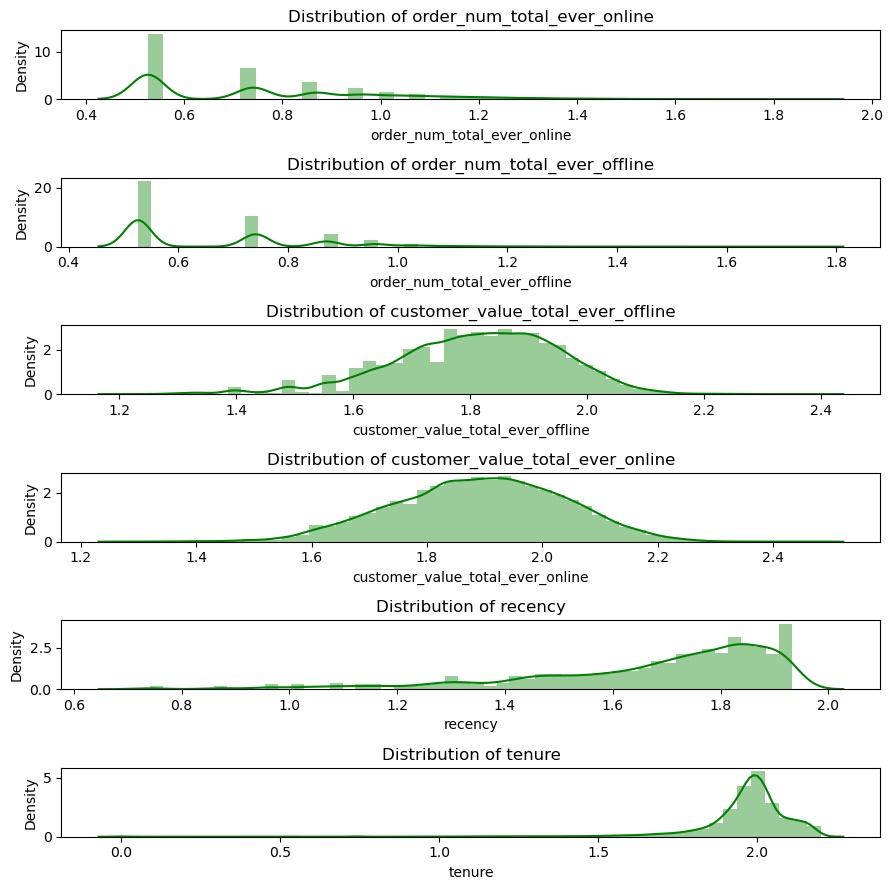

In [26]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

plt.figure(figsize=(9, 9))
plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total_ever_online')
plt.subplot(6, 1, 2)
check_skew(model_df,'order_num_total_ever_offline')
plt.subplot(6, 1, 3)
check_skew(model_df,'customer_value_total_ever_offline')
plt.subplot(6, 1, 4)
check_skew(model_df,'customer_value_total_ever_online')
plt.subplot(6, 1, 5)
check_skew(model_df,'recency')
plt.subplot(6, 1, 6)
check_skew(model_df,'tenure')
plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)
plt.show()

* Normal dağılımın sağlanması için Log transformation uygulanması

In [28]:
import warnings
from pandas.errors import SettingWithCopyWarning

# SettingWithCopyWarning uyarısını kapatma
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Diğer kodlarınızı buraya ekleyebilirsiniz

model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
model_df['customer_value_total_ever_offline']=np.log1p(model_df['customer_value_total_ever_offline'])
model_df['customer_value_total_ever_online']=np.log1p(model_df['customer_value_total_ever_online'])
model_df['recency']=np.log1p(model_df['recency'])
model_df['tenure']=np.log1p(model_df['tenure'])
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.67,0.42,1.02,1.11,1.00,1.01
1,0.87,0.55,1.03,1.15,1.01,1.14
2,0.63,0.55,1.04,1.08,1.04,1.08
3,0.42,0.42,0.94,0.99,1.02,0.81
4,0.42,0.42,0.95,1.03,0.99,1.10


* Scaling

In [29]:
sc = MinMaxScaler((0, 1))
model_scaling = sc.fit_transform(model_df)
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.40,0.00,0.54,0.68,0.85,0.87
1,0.72,0.22,0.56,0.77,0.87,0.98
2,0.33,0.22,0.58,0.61,0.93,0.93
3,0.00,0.00,0.33,0.39,0.90,0.70
4,0.00,0.00,0.37,0.49,0.84,0.94


##### 2. Optimum küme sayısını belirleyiniz.

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(model_df)
elbow.show()

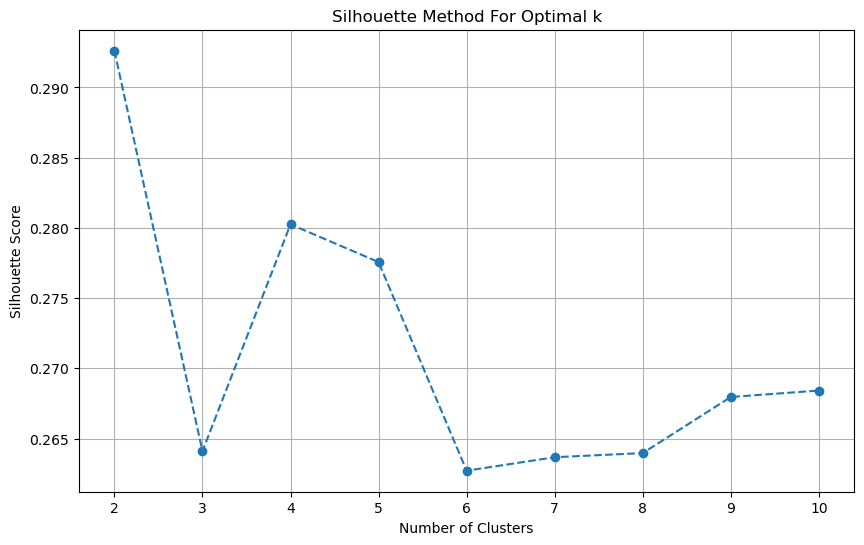

In [30]:
sil_scores = []

for i in range(2, 11):  # Silhouette score is only defined for 2 or more clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(model_df)
    cluster_labels = kmeans.labels_
    sil_score = silhouette_score(model_df, cluster_labels)
    sil_scores.append(sil_score)

# Plot
plt.figure(figsize=(10,6))
plt.plot(range(2, 11), sil_scores, marker='o', linestyle='--')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

##### 3. Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.

In [31]:
k_means = KMeans(n_clusters = 7, random_state= 42).fit(model_df)
segments=k_means.labels_
segments

final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,0
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,5
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,2
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,2


##### 4. Herbir segmenti istatistiksel olarak inceleyeniz.

In [32]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                customer_value_total_ever_online                 recency               tenure                   
                               mean  min    max                         mean  min    max                              mean   min      max                             mean    min      max    mean   min    max    mean  min     max count
segment                                                                                                                                                                                                                                   
0                              8.25 3.00 130.00                         1.02 1.00   2.00                            126.44 10.49  1263.76                          1312.05 192.20 36687.80  111.78  4.00 367.00  974.64 7.00 2999.00  2174
1                              2.59 2.00   6.00                         3.04 2.00 109.00                            389.43 66.63 10239.46                           398.77  69.99  2105.94  152.34 11.00 367.00  712.98 2.00 2921.00  2866
2                              1.00 1.00   2.00                         1.01 1.00   2.00                            142.38 10.49  1406.85                           168.76  12.99  1519.17  162.37 12.00 367.00  442.71 0.00 2604.00  4423
3                              1.00 1.00   3.00                         2.95 2.00  87.00                            397.14 49.97 18119.14                           166.19  14.99  2587.20  150.53 11.00 367.00  596.29 0.00 2750.00  3553
4                              2.55 2.00   5.00                         1.01 1.00   2.00                            133.75 10.00  1359.47                           406.93  50.00  4271.45  162.67 19.00 367.00  595.37 0.00 2922.00  3415
5                              8.46 3.00 200.00                         3.18 2.00  46.00                            409.93 64.97  7247.60                          1318.07 174.96 45220.13   95.35  4.00 365.00 1030.53 3.00 3034.00  1877
6                              2.51 1.00  36.00                         1.77 1.00  14.00                            248.33 12.99  2245.33                           441.79  29.74  9723.33    8.95  2.00  24.00  668.14 0.00 3031.00  1637

#### GÖREV 3: Hierarchical Clustering ile Müşteri Segmentasyonu

##### 1. Adım: Görev 2'de standarlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz.

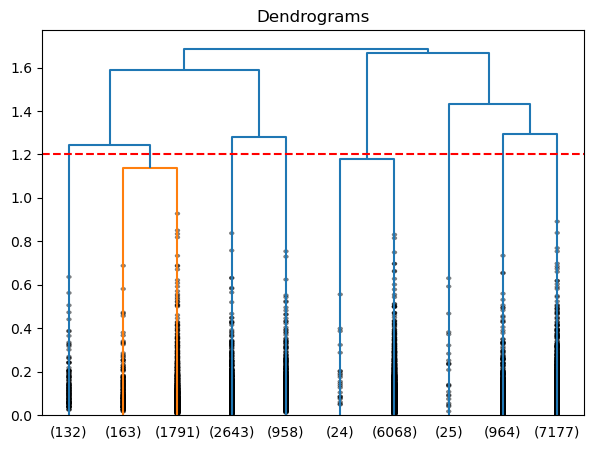

In [33]:
hc_complete = linkage(model_df, 'complete')

plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()

##### 2. Adım: Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.


In [34]:
hc = AgglomerativeClustering(n_clusters=5)
segments = hc.fit_predict(model_df)

final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,1
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,4
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,4


##### 3. Herbir segmenti istatistiksel olarak inceleyeniz.


In [35]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                customer_value_total_ever_online                recency              tenure                    
                               mean  min    max                         mean  min    max                              mean   min      max                             mean   min      max    mean   min    max   mean   min     max count
segment                                                                                                                                                                                                                                  
0                              3.45 1.00 130.00                         1.63 1.00  14.00                            219.43 12.99  2245.33                           586.01 23.99 36687.80   19.40  2.00  98.00 682.10  1.00 3034.00  3932
1                              4.91 2.00 200.00                         3.11 1.00 109.00                            396.39 19.98 10239.46                           765.25 58.18 45220.13  140.97  6.00 367.00 841.12 24.00 3028.00  4399
2                              1.00 1.00   3.00                         3.00 2.00  87.00                            401.04 13.98 18119.14                           165.59 14.99  2587.20  164.92 11.00 367.00 590.75  2.00 2750.00  3228
3                              4.45 2.00  59.00                         1.00 1.00   2.00                            132.16 10.00  1359.47                           681.91 39.98 30688.47  170.69 18.00 367.00 739.93  2.00 2964.00  4428
4                              1.00 1.00   4.00                         1.00 1.00   2.00                            146.09 10.49  1406.85                           175.48 12.99  1519.17  176.14 11.00 367.00 438.29  0.00 2604.00  3958